In [1]:
import numpy as np
import pandas as pd

import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import json

In [2]:
graph = np.load('../data/clean/graph.wse.npy')
graph.shape

(1159831, 3)

# Node degree exploration

The code mainly is from Haoxin's.

In [3]:
# explore node degree distribution
def generate_deg_dist(graph, data_type='whole',title='for the whole graph'):
    if data_type == "whole":
        edges1 = Counter(list(Counter(graph[:,0]).values()))
        edges2 = Counter(list(Counter(graph[:,2]).values()))
    
    elif data_type == "gene":
        graph1 = graph[graph[:,0]>=11171+8079]
        graph2 = graph[graph[:,2]>=11171+8079+18643]
        edges1 = Counter(list(Counter(graph1[:,0]).values()))
        edges2 = Counter(list(Counter(graph2[:,2]).values()))
        
    elif data_type == "disease":
        graph1 = graph[(graph[:,0]>=8079) & (graph[:,0]<11171+8079)]
        graph2 = graph[(graph[:,2]>=8079) & (graph[:,2]<11171+8079)]
        edges1 = Counter(list(Counter(graph1[:,0]).values()))
        edges2 = Counter(list(Counter(graph2[:,2]).values()))
    elif data_type == "drug":
        graph1 = graph[graph[:,0]<8079]
        graph2 = graph[graph[:,2]<8079]
        edges1 = Counter(list(Counter(graph1[:,0]).values()))
        edges2 = Counter(list(Counter(graph2[:,2]).values()))
    edges = edges1+edges2
    plt.scatter(list(edges.keys()),list(edges.values()))
    plt.title('Degree Distribution '+title)
    plt.xlabel('Node Degree')
    plt.ylabel('Number of Nodes')
    plt.yscale('log')

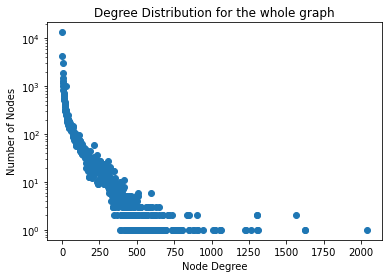

In [4]:
generate_deg_dist(graph, title='for the whole graph')

In [22]:
max_node = np.max(graph[:,0])
max_node

37892

In [23]:
drug_num = 8079 # 1st in edges
disease_num = 11171 # 2nd in edges
gene_num = 18643 # 3rd in edges
drug_num + disease_num + gene_num

37893

# Pruning

In [3]:
covid_gene_dict = json.load(open('../data/clean/covid-gene-num-dict.wse.json'))
covid_num_gene_dict = {num:gene for (gene, num) in covid_gene_dict.items()}
covid_genes = covid_gene_dict.values()

In [4]:
gene_drug_targets = pd.read_csv('../data/clean/covid-gene-drug-targets', header=None)
gene_drug_targets = list(set(gene_drug_targets[0].tolist()))
print(gene_drug_targets)

['NDUFAF2', 'CSNK2A2', 'ZYG11B', 'NUP98', 'F2RL1', 'ABCC1', 'TOR1A', 'OS9', 'EIF4E2', 'FKBP7', 'NUP214', 'PLOD2', 'MRPS25', 'MARK3', 'UGGT2', 'SIGMAR1', 'NUP58', 'RBX1', 'EDEM3', 'BRD2', 'TMEM97', 'MARK2', 'NUP210', 'PRKACA', 'FKBP10', 'NDUFAF1', 'GLA', 'NEK9', 'ELOC', 'PTGES2', 'FKBP15', 'NUP54', 'SIL1', 'DCTPP1', 'TBK1', 'MRPS2', 'IMPDH2', 'COMT', 'RAE1', 'NDUFB9', 'HDAC2', 'DNMT1', 'LOX', 'CUL2', 'HYOU1', 'FOXRED2', 'ERLEC1', 'NUP88', 'SDF2', 'ELOB', 'RIPK1', 'NGLY1', 'ERO1B', 'CSNK2B', 'LARP1', 'MRPS27', 'EIF4H', 'MRPS5', 'BRD4', 'CEP250', 'NUP62', 'ATP6AP1']


In [8]:
covid_graph = graph[np.isin(graph[:,0], list(covid_genes)) | np.isin(graph[:,2], list(covid_genes))]
Counter(covid_graph[:,1])

Counter({1: 1,
         2: 46,
         3: 222,
         4: 73,
         5: 31766,
         6: 9212,
         7: 10352,
         8: 4366,
         9: 342,
         10: 1294,
         11: 270,
         12: 1703})

In [9]:
G = nx.Graph()
nx_edges = [(node1, node2) for (node1, node2) in zip(graph[:,0],graph[:,2])]
G.add_edges_from(nx_edges)
degrees = dict(G.degree())

In [10]:
len(list(G.edges()))

638289

In [11]:
DEGREE_THRESH = 500
HOPS = 2

In [13]:
covid_neighbors = []
def get_neighbors(node, hop, max_hops):
    if node in covid_neighbors or hop > max_hops: return
    covid_neighbors.append(node)
    for neighbor in dict(G[node]).keys():
        get_neighbors(neighbor, hop+1, max_hops)
for gene_num in covid_genes:
    get_neighbors(gene_num, 0, HOPS)

In [15]:
remove_nodes = [node for node,degree in dict(G.degree()).items()\
                if degree < DEGREE_THRESH and\
                node not in covid_genes and node not in covid_neighbors]
len(remove_nodes)

27015

In [16]:
final_graph = graph[~((np.isin(graph[:,0], remove_nodes)) | (np.isin(graph[:,2], remove_nodes))),:]
final_graph.shape

(880648, 3)

In [17]:
G2 = nx.Graph()
G2.add_edges_from([(node1, node2) for (node1, node2) in zip(final_graph[:,0], final_graph[:,2])])
[len(c) for c in sorted(nx.connected_components(G2), key=len, reverse=True)]

[10876, 2]

In [18]:
for component in sorted(nx.connected_components(G2), key=len, reverse=True):
    included_nodes = list(component)
    break

In [19]:
final_graph_2 = final_graph[np.isin(final_graph[:,0], included_nodes) & np.isin(final_graph[:,2], included_nodes),:]
final_graph_2.shape

(880646, 3)

In [20]:
covid_graph = final_graph_2[np.isin(final_graph_2[:,0], list(covid_genes)) | np.isin(final_graph_2[:,2], list(covid_genes))]
Counter(covid_graph[:,1])

Counter({2: 14,
         3: 92,
         4: 71,
         5: 28950,
         6: 8310,
         7: 9314,
         8: 4126,
         9: 294,
         10: 1192,
         11: 242,
         12: 1204})

In [ ]:
'''
import numpy as np
from prune import prune_graph
graph = np.load('../data/clean/graph.wse.npy')
prune_graph(graph, disease_degree_thresh=500, drug_degree_thresh=500)
'''